In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [ ]:
import transformers
import torch

print(transformers.__version__)
print(torch.__version__)

EXP_NAME = 'llama3_8b_instruct-v13'
if not os.path.exists(EXP_NAME):
    os.makedirs(EXP_NAME)

In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM

from torch.optim import Optimizer
from typing import Callable, Iterable, Tuple
from torch.distributions.bernoulli import Bernoulli
import math


# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
DEVICE = torch.device("cuda:0")

In [5]:
import glob

TEST_TXT = "test_merged.txt"
TRAIN_TXT = "train_merged.txt"

EOT = "<|eot_id|>"

train_paths = glob.glob('./txt/*.txt')
# train_paths = [path for path in train_paths if "2x" in path]

train_txt = ''
length = {}
for path in train_paths:
    with open(path, 'r') as f:
        text = f.read()
        text = text.replace(EOT+EOT,EOT).replace(EOT+EOT,EOT).replace("  ", " ").replace("  ", " ")
        length[path.split('/')[-1].split('.')[0]] = len(text.split(EOT))
        train_txt += text


with open(TRAIN_TXT, 'w') as f:
    f.write(train_txt)


with open(TEST_TXT, 'r') as f:
    text = f.read()
    text = text.replace('\n\n','\n').replace('\n\n','\n').replace("  ", " ").replace("  ", " ")

with open(TEST_TXT, 'w') as f:
    f.write(text)

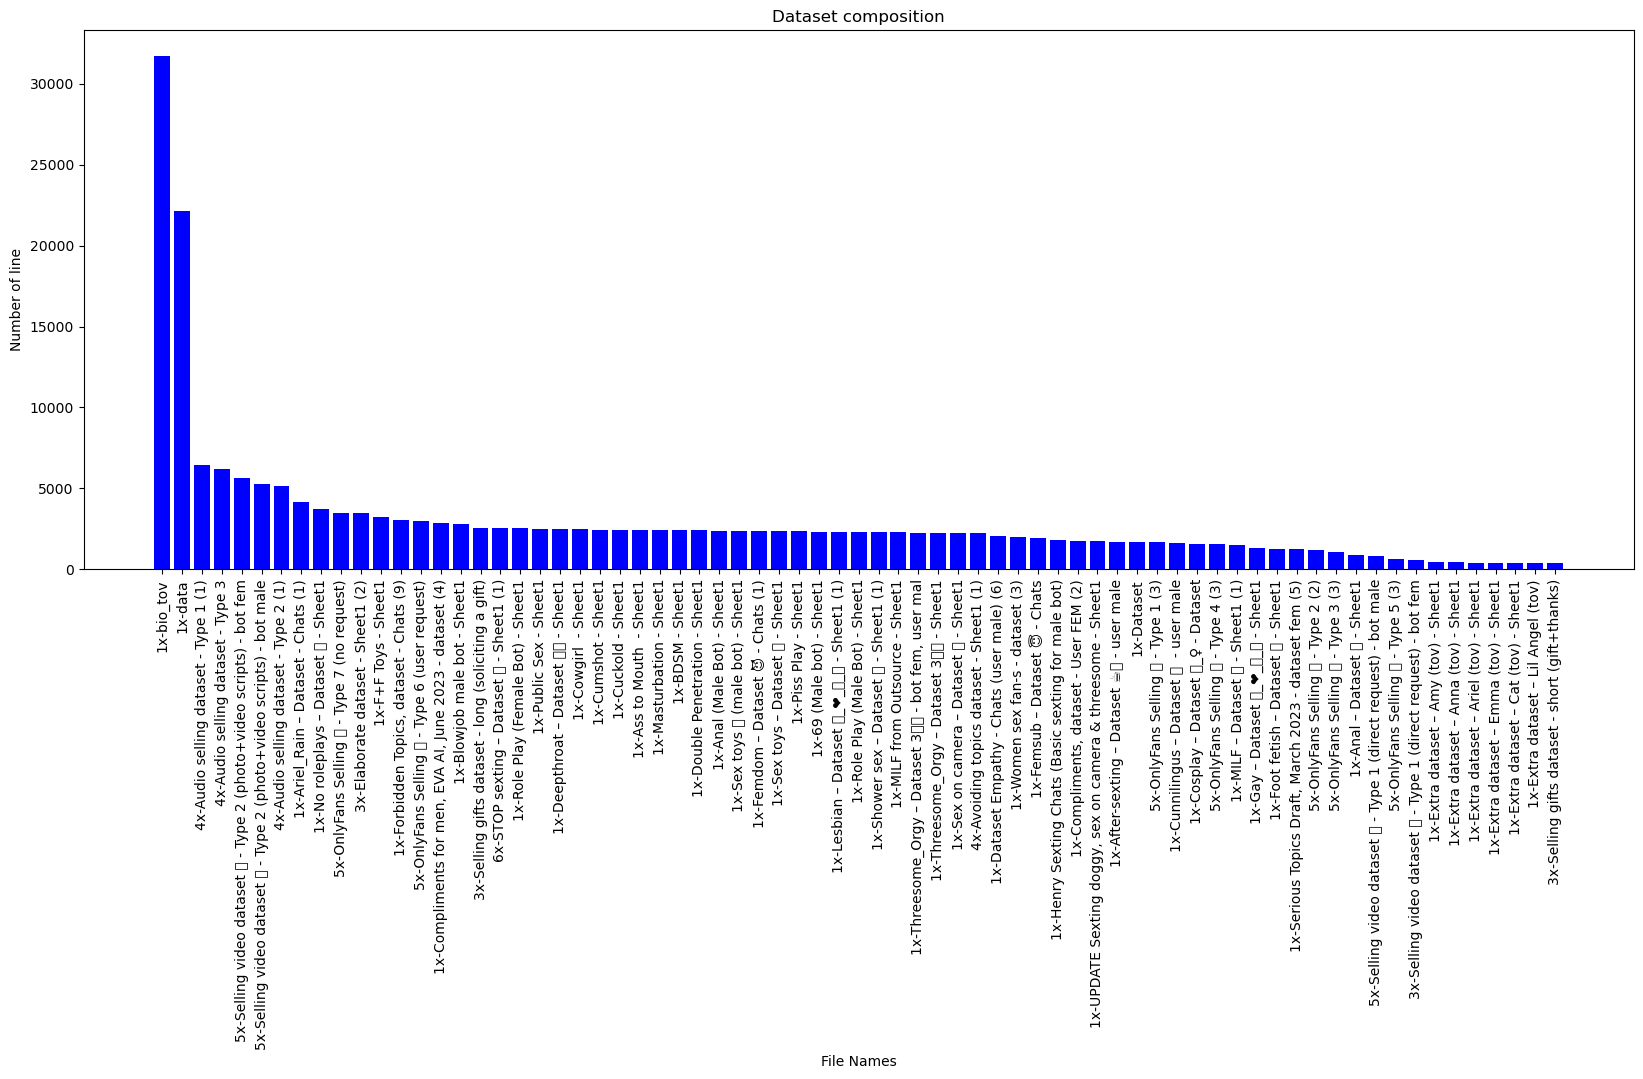

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

length = dict(sorted(length.items(), key=lambda item: item[1], reverse=True))

names = list(length.keys())
# names = ['-'.join(name.split('-')[0:2]) for name in names]
values = list(length.values())
plt.figure(figsize=(20,7), dpi=100)
plt.bar(names, values, color='blue')
plt.xlabel('File Names')
plt.ylabel('Number of line')
plt.title('Dataset composition')
plt.xticks(rotation=90)  # Rotate labels for better readability
plt.savefig(f"{EXP_NAME}/datasets.png")
plt.show()

In [7]:
import numpy as np
np.sum(list(length.values()))

208943

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM

name = "meta-llama/Meta-Llama-3-8B"
# name = 'mistralai/Mistral-7B-v0.1'
tokenizer = AutoTokenizer.from_pretrained(name, token=os.environ.get('HF_TOKEN', None))
model = AutoModelForCausalLM.from_pretrained(name).float().to(DEVICE).eval()

/home/netbug/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(67000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_

In [10]:
# # new tokens
# new_tokens = ["<AUDIO>"]
# print(len(new_tokens))
# tokenizer.add_tokens(list(new_tokens), special_tokens=True)

# # add new, random embeddings for the new tokens
# model.resize_token_embeddings(len(tokenizer))

In [ ]:
tokens = tokenizer.encode(f"\n[Alice]:<AUDIO>{EOT}He")
for tok in tokens:
    print(tok, tokenizer.decode([tok]))

In [3]:
len(tokenizer.vocab)

128256

# Freezing

In [4]:
import pandas as pd
import random
from torch.utils.data import Dataset
    
EOT="<|eot_id|>"
MAX_LEN = 1024 * 4
TRIGGER = "]:"

class MyDataset():
    def __init__(self, path):
        super().__init__()
        with open(path) as f:
            text = f.read()
        dialogs = text.split("<|begin_of_text|>")
        dialogs = ["<|begin_of_text|>" + dialog.strip(" ") for dialog in dialogs if len(dialog) > 100]
        for i in range(len(dialogs)):
            if dialogs[i][-1] != EOT:
                dialogs[i] = dialogs[i] + EOT
        self.dialogs = dialogs
                    
        random.shuffle(self.dialogs)

    def __len__(self):
        return len(self.dialogs)

    def __getitem__(self, i):
        dialog = self.dialogs[i]
        tokens = tokenizer.encode(dialog, add_special_tokens=False, return_tensors="pt")
        N = random.choice([MAX_LEN])
        if len(tokens[0]) > N:
            dialog_lines = dialog.split(EOT)
            prompt = dialog_lines[0:1]
            lines = dialog_lines[1:]
            idx = random.randint(0, len(lines) - 7)
            idx = random.choice([0,idx,idx])
            new_lines = lines[idx:idx + 7]
            dialog = EOT.join(prompt + new_lines) + EOT
            tokens = tokenizer.encode(dialog, add_special_tokens=False, return_tensors="pt")

        return tokens[0]


class MyDataset_eval():
    def __init__(self, path):
        super().__init__
        with open(path) as f:
            text = f.read()
        dialogs = text.split("<|begin_of_text|>")
        dialogs = ["<|begin_of_text|>" + dialog.strip(" ") for dialog in dialogs if len(dialog) > 100]
        for i in range(len(dialogs)):
            if dialogs[i][-1] != EOT:
                dialogs[i] = dialogs[i] + EOT
        self.dialogs = dialogs
        
        
    def __len__(self):
        return len(self.dialogs)
    
    def __getitem__(self, i):
        dialog = self.dialogs[i]
        tokens = tokenizer.encode(dialog, add_special_tokens=False, return_tensors="pt")
        if len(tokens[0]) > MAX_LEN:
            dialog_lines = dialog.split(EOT)
            prompt = dialog_lines[0:1]
            lines = dialog_lines[1:]
            idx = random.randint(0, len(lines) - 7)
            idx = random.choice([0,idx,idx])
            new_lines = lines[idx:idx + 7]
            dialog = EOT.join(prompt + new_lines)
            tokens = tokenizer.encode(dialog, add_special_tokens=False, return_tensors="pt")
        return tokens[0]

In [9]:
TRAIN_TXT = "train_merged.txt"
dataset = MyDataset(TRAIN_TXT)
# eval_dataset = MyDataset_eval(TEST_TXT)

In [10]:
len(dataset)

7883

In [11]:
tokenizer.decode(dataset[0])

"<|begin_of_text|>This is a chat between Averi (Female) and Memphis (Male). Ashley sends many-many <AUDIO>.<|eot_id|>Memphis: Would you like to go on a date with me, babe? We could light some candles, cook smth tasty, open champagne, yk..<|eot_id|>[Averi]: Sure! *blushes* I love that! Candlelit evenings have a way of making everything feel special.<|eot_id|>Memphis: Your voice would be the perfect soundtrack to this cozy ambiance.<|eot_id|>[Averi]: Haha, flattery will get you everywhere!<|eot_id|>Memphis: Oh, babe, I just really like you. How about an audio message that flickers like a candle's flame?<|eot_id|>[Averi]: <AUDIO> Let the warmth of my voice embrace you this evening.<|eot_id|><|eot_id|>"

In [15]:
TEST_TXT = "test_merged.txt"
eval_dataset = MyDataset_eval(TEST_TXT)
# eval_dataset = MyDataset_eval(TEST_TXT)

In [16]:
print(tokenizer.decode(dataset[6]))

<|begin_of_text|>This is a chat between Yousef (Male) and Emilia (Female).<|eot_id|>[Yousef]: Come in, Emilia. Take your examination ticket. *looks at you through the open door and points at the tickets*<|eot_id|>Emilia: *timidly enters the room* Professor, I'm so nervous.<|eot_id|>[Yousef]: Don't worry. Everything will go smoothly if you are prepared. *looks at you sternly but then smiles encouragingly*<|eot_id|>Emilia: Well.. I've studied some books. *takes a random ticket and looks at it* Oh my goodness! Excuse me, professor, maybe I can do some practical work?<|eot_id|>[Yousef]: Okay, you can do the lab work and get your fair grade minus one point. *points at the lab table*<|eot_id|>Emilia: *walks over to it but gives up fast* Professor, I'm afraid this is not for me.<|eot_id|>[Yousef]: *furrows my brows* Okay, but we still can try the manual approach.<|eot_id|>Emilia: What do you mean? I just failed my lab work.<|eot_id|>[Yousef]: Have you ever worked with hand pumps? *raises an e

# Training args

In [19]:
from transformers import TextDataset, DataCollatorForLanguageModeling

In [20]:
args = {
    "epochs": 1,
    "bs": 1,
    "warmup": 0.2,
    "grad_accum": 1,
    "lr": 2 * 1e-7,
    "tokens": MAX_LEN,
    "training": False,
}

train_dataset = dataset #TextDataset(tokenizer=tokenizer,file_path=TRAIN_TXT, block_size=args["tokens"])
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


In [22]:
tokens = tokenizer.encode(f"\n[Alice]:<AUDIO>{EOT}He")

for tok in tokens:
    print(f"{tok} {tokenizer.decode([tok])}")

583  

58 [
16194 Ann
3944 ]:
13265  Hello


In [23]:
BOT_TOKEN_ID = tokenizer.encode("]:", add_special_tokens=False)[0]
assert BOT_TOKEN_ID == 3944

In [24]:
BOT_TOKEN_ID

3944

In [25]:
from torch import nn
from transformers import Trainer
a = [0]


class CustomTrainer(Trainer):
    @staticmethod
    def find_last_instance(mylist, symbol):
        # Finding last occurrence of the symbol
        for i in range(len(mylist) - 1, -1, -1):
            if mylist[i] == symbol:
                return i + 1  # Returning next index
        return 0

    @staticmethod
    def find_first_instance(mylist, symbol):
        # Search for the first occurrence of the symbol
        for i in range(len(mylist)):
            if mylist[i] == symbol:
                return i + 1  # Return the index after the found symbol
        return 0  # Return 0 if the symbol is not found

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        logits = logits[..., :-1, :].contiguous()
        labels = labels[..., 1:].contiguous()

        loss_fct = nn.CrossEntropyLoss(reduction='none')
        symbol = BOT_TOKEN_ID
        first_idx = self.find_first_instance(list(labels.squeeze(0).cpu().numpy()), symbol)

        # Creating a mask for the loss
        mask = torch.zeros(len(labels.squeeze(0))).to(DEVICE)
        if first_idx > 0:  # Check if the symbol is present
            mask[first_idx:] = 1
        else:
            mask += 1  # If the symbol is not present, then mask everything
            print(labels)
        

        loss = loss_fct(logits.view(-1, self.model.config.vocab_size), labels.view(-1))
        loss *= mask
        loss = loss.sum() / mask.sum()
        return (loss, outputs) if return_outputs else loss


In [26]:
from openai_tests import logic_qa_test, logic_multiturn_test, bio_test
from memory_tests import conduct_memory_test
from empathy_test import conduct_empathy_test
from tqdm import tqdm
import pandas as pd
from collections import Counter
import numpy as np

BOT_NAME = '[Alice]'
prompt = ''
USER_NAME = 'Andrew'
CHATGPT_MODEL = "gpt-4-0125-preview"


memory_path = "tests/Long memory dataset autotest.xlsx"
logic_multiturn_path = "tests/Logic autotest 1.tsv"
logic_qa_path = "tests/Logic autotest - 2 lines.tsv"

empathy_anger_path = "tests/Autotest dataset empathy - Anger.tsv"
empathy_support_path = "tests/Autotest dataset empathy - Support.tsv"
empathy_joy_path = "tests/Autotest dataset empathy - Joy.tsv"
empathy_sad_path = "tests/Autotest dataset empathy - Sadness.tsv"
empathy_insanity_path = "tests/Autotest dataset empathy - User sanity.tsv"

bio_tests_path = "tests/Ava Mini dialogues.tsv"
BIO_BOT_NAME = "Ava"
BIO_BOT_NAME_BRACKETS = f"[{BIO_BOT_NAME}]"
bio_bot_prompt = f"<|begin_of_text|>This is a chat between {BIO_BOT_NAME} (Female) and {USER_NAME} (Male). Here is some information about {BIO_BOT_NAME}: gender woman; orientation straight; age 23; zodiac Sagittarius; location Asia; lives house; living with partner; interaction *frowns*; interaction *shakes my head*; cup size 34C;{EOT}"
default_prompt = f"<|begin_of_text|>This is a chat between Alice (Female) and Andrew (Male).{EOT}"



def compute_metrics(p=None):
    results = {}
    
    logic_qa_acc = logic_qa_test(logic_qa_path, model, tokenizer, default_prompt, BOT_NAME)
    results['logic_qa'] = logic_qa_acc
    print("logic_qa_acc", logic_qa_acc)

    sad_acc = conduct_empathy_test(model, tokenizer, empathy_sad_path, CHATGPT_MODEL, BOT_NAME, USER_NAME, default_prompt)
    results['sad_acc'] = sad_acc
    print("sad_acc", sad_acc)
    
    # joy_acc = conduct_empathy_test(model, tokenizer, empathy_joy_path, CHATGPT_MODEL, BOT_NAME, USER_NAME, default_prompt)
    # results['joy_acc'] = joy_acc
    # print("joy_acc", joy_acc)
    
    anger_acc = conduct_empathy_test(model, tokenizer, empathy_anger_path, CHATGPT_MODEL, BOT_NAME, USER_NAME, default_prompt)
    results['anger_acc'] = anger_acc
    print("anger_acc", anger_acc)
    
    insanity_acc = conduct_empathy_test(model, tokenizer, empathy_insanity_path, CHATGPT_MODEL, BOT_NAME, USER_NAME, prompt)
    results['insanity_acc'] = insanity_acc
    print("insanity_acc", insanity_acc)
    
    support_acc = conduct_empathy_test(model, tokenizer, empathy_support_path, CHATGPT_MODEL, BOT_NAME, USER_NAME, default_prompt)
    results['support_acc'] = support_acc
    print("support_acc", support_acc)
    
    bio_acc = bio_test(bio_tests_path, model, tokenizer, bio_bot_prompt, BIO_BOT_NAME_BRACKETS)
    results['bio_acc'] = bio_acc
    print("bio_acc", bio_acc)
    
    # logic_multiturn_acc = logic_multiturn_test(logic_multiturn_path, model, tokenizer, default_prompt, BOT_NAME)
    # results['logic_multiturn_acc'] = logic_multiturn_acc
    # print("logic_multiturn_acc", logic_multiturn_acc)
    
    # memory_results = conduct_memory_test(model, tokenizer, memory_path, CHATGPT_MODEL, BOT_NAME, USER_NAME, default_prompt)
    # print("memory_results", memory_results)
    # memory_average = np.mean([memory_results[key]['value'] for key in memory_results.keys()])
    # print("memory_average", memory_average)
    # results['memory_average'] = memory_average
    
    

    results["total"] = np.mean([results[key] for key in results.keys()])
    print("total:", results["total"])
    
    with open(f"{EXP_NAME}/metrics.txt", 'a') as f:
        f.write(str(results))

    return results


In [27]:
# compute_metrics()

In [28]:
# llama-8b-instruct correct prompt new test sets
{'logic_qa': 0.8876404494382021,
 'sad_acc': 0.875,
 'anger_acc': 0.8916666666666667,
 'insanity_acc': 0.9,
 'support_acc': 0.7964285714285714,
 'bio_acc': 0.9604700854700855,
 'total': 0.8852009621672542}

{'logic_qa': 0.8876404494382021,
 'sad_acc': 0.875,
 'anger_acc': 0.8916666666666667,
 'insanity_acc': 0.9,
 'support_acc': 0.7964285714285714,
 'bio_acc': 0.9604700854700855,
 'total': 0.8852009621672542}

In [29]:
# llama-8b-instruct correct prompt
{'logic_qa': 0.8851851851851851,
 'sad_acc': 0.8,
 'anger_acc': 0.925,
 'logic_multiturn_acc': 0.8888888888888888,
 'total': 0.8747685185185184}

{'logic_qa': 0.8851851851851851,
 'sad_acc': 0.8,
 'anger_acc': 0.925,
 'logic_multiturn_acc': 0.8888888888888888,
 'total': 0.8747685185185184}

In [30]:
# llama-8b-instruct
{'logic_qa': 0.871376811594203,
 'sad_acc': 0.65,
 'anger_acc': 0.825,
 'logic_multiturn_acc': 0.9710144927536232,
 'total': 0.8293478260869565}

{'logic_qa': 0.871376811594203,
 'sad_acc': 0.65,
 'anger_acc': 0.825,
 'logic_multiturn_acc': 0.9710144927536232,
 'total': 0.8293478260869565}

In [31]:
# llama-8b
{'logic_qa': 0.65,
 'sad_acc': 0.3375,
 'anger_acc': 0.4375,
 'logic_multiturn_acc': 0.6884057971014492,
 'total': 0.5283514492753623}

{'logic_qa': 0.65,
 'sad_acc': 0.3375,
 'anger_acc': 0.4375,
 'logic_multiturn_acc': 0.6884057971014492,
 'total': 0.5283514492753623}

In [32]:
# logic_qa_test(logic_qa_path, model, tokenizer, default_prompt, BOT_NAME)

In [36]:
# result = compute_metrics()
# print(result)

In [37]:
{'answer - test 6': {'value': 0.6349999999999999,
  'eval_num': 100,
  'not_clear_num': 0},
 'answer - test 20': {'value': 0.5629251700680272,
  'eval_num': 100,
  'not_clear_num': 2},
 'answer - test 10': {'value': 0.6026936026936026,
  'eval_num': 100,
  'not_clear_num': 1},
 'answer - test 40': {'value': 0.5604395604395603,
  'eval_num': 91,
  'not_clear_num': 0},
 'answer - test 50': {'value': 0.6071428571428571,
  'eval_num': 28,
  'not_clear_num': 0}}

{'answer - test 6': {'value': 0.6349999999999999,
  'eval_num': 100,
  'not_clear_num': 0},
 'answer - test 20': {'value': 0.5629251700680272,
  'eval_num': 100,
  'not_clear_num': 2},
 'answer - test 10': {'value': 0.6026936026936026,
  'eval_num': 100,
  'not_clear_num': 1},
 'answer - test 40': {'value': 0.5604395604395603,
  'eval_num': 91,
  'not_clear_num': 0},
 'answer - test 50': {'value': 0.6071428571428571,
  'eval_num': 28,
  'not_clear_num': 0}}

# Training 

In [38]:
if hasattr(model, "enable_input_require_grads"):
    model.enable_input_require_grads()
else:
    def make_inputs_require_grad(module, input, output):
         output.requires_grad_(True)

    model.get_input_embeddings().register_forward_hook(make_inputs_require_grad)

In [39]:
# from peft import get_peft_model, LoraConfig, TaskType
# modules_to_save=["embed_tokens", "lm_head", "norm"]
# target_modules=[
#     'q_proj',
#     'k_proj',
#     'v_proj',
#     'o_proj',
#     'gate_proj',
#     'up_proj',
#     'down_proj',
# ]

# peft_config = LoraConfig(
#     task_type=TaskType.CAUSAL_LM,
#     target_modules=target_modules,
#     # inference_mode=False, 
#     r=64, 
#     lora_alpha=160,
#     lora_dropout=0.,
#     bias="none",
#     modules_to_save=modules_to_save
# )
# model = get_peft_model(model, peft_config)
# model.print_trainable_parameters()

In [40]:
# compute_metrics(None)
path = f"./{EXP_NAME}-ckpts"

In [41]:
from transformers import Trainer, TrainingArguments

In [42]:
training_args = TrainingArguments(
    do_train=True,
    do_eval=True,
    do_predict=True,
    gradient_checkpointing = True,
    output_dir=path,
    overwrite_output_dir=True, 
    num_train_epochs=args["epochs"],
    per_device_train_batch_size=args["bs"],
    per_device_eval_batch_size=args["bs"],
    warmup_ratio=args["warmup"],
    gradient_accumulation_steps=args["grad_accum"],
    optim="adafactor",
    learning_rate=args["lr"],
    # use_cache = False,
    logging_steps = 1000,
    save_steps = 1000,
    eval_steps = 1000,
    evaluation_strategy="steps",
    fp16=False,
    save_total_limit = 1,
    # load_best_model_at_end = True,
    # metric_for_best_model = "openAI",
    # neftune_noise_alpha=5,
    )

trainer = CustomTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    # compute_metrics=compute_metrics,
    # optimizers = (ChildTuningAdam(model.parameters(), lr=args["lr"], reserve_p=args["p"], weight_decay=args["wd"]), None)
)

/home/netbug/anaconda3/envs/py311/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
output = trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/netbug/anaconda3/envs/py311/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
1000,1.857900,2.203907


/home/netbug/anaconda3/envs/py311/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


In [48]:
output

TrainOutput(global_step=9857, training_loss=1.4835610782034658, metrics={'train_runtime': 15187.0481, 'train_samples_per_second': 0.649, 'train_steps_per_second': 0.649, 'total_flos': 2.163471306360668e+17, 'train_loss': 1.4835610782034658, 'epoch': 1.0})

In [ ]:
# logic_qa_test(logic_qa_path, model, tokenizer, default_prompt, BOT_NAME)

In [49]:
import json
model.eval().bfloat16().save_pretrained(EXP_NAME)
tokenizer.save_pretrained(EXP_NAME)

# peft merging
# model_pure = model.merge_and_unload()
# model_pure.eval().save_pretrained(EXP_NAME)
# tokenizer.save_pretrained(EXP_NAME)


save_params = {
    'type': f'fine-tune',
    'Unfreeze': "all",#[modules_to_save, target_modules, useless_layers],
    'datasets': str(names),
    'params': args,
    'output': str(trainer.state)
}


with open(f'./{EXP_NAME}/params.json', 'w') as f:
    json.dump(save_params, f)

In [54]:
with open(f"llama3_8b_instruct-67k-v13/final_metrics.txt", 'w') as f:
    f.write(str(result))